# Actividad 1 – Machine Learning II

Profesor: Francisco Pérez Galarce                                                              
Formato de entrega. Un notebook en Python con: Código limpio, celdas ordenadas y comentarios. Gráficos y tablas
de resultados.
Dentro del mismo notebook usando Markdown debe incluir: Descripción del preprocesamiento. Comparación de
modelos (sin polínomios vs. con polínomios; sin penalización vs. penalizados). Discusión de resultados y conclusiones.
La actividad puede ser desarrollada en grupos de máximo 3 personas.  
El avance de cada grupo será discutido al final de la clase del próximo sábado 06 de diciembre.

## CONTEXTO
Una empresa de telecomunicaciones desea predecir qué clientes tienen mayor probabilidad de fugarse
(churn), para diseñar campañas de retención. Se cuenta con un dataset de clientes, sus características de uso y
una etiqueta binaria que indica si el cliente se fue (churn = 1) o se mantuvo (churn = 0). El objetivo de esta
actividad es construir y evaluar modelos de regresión logística, comparando:
1. Un modelo con features “básicas” (preprocesadas).
2. Un modelo con transformaciones polinomiales sobre las features numéricas.
3. Modelos con penalización (regularización) para controlar complejidad.
La evaluación debe realizarse mediante validación cruzada k-fold, utilizando matriz de confusión, curva ROC y
curva Precision–Recall, en línea con lo visto en la clase.  
Al finalizar la actividad, la o el estudiante será capaz de:
• Implementar un flujo completo de preprocesamiento de datos para un problema de churn.
• Entrenar modelos de regresión logística con y sin transformaciones polinomiales.
• Incorporar penalizaciones (L2, L1 o elastic net) para controlar sobreajuste.
• Evaluar clasificadores con k-fold cross-validation mediante:
✓ Matriz de confusión y métricas asociadas (accuracy, precision, recall, F1).  
✓ Curva ROC y AUC.  
✓ Curva Precision–Recall y PR-AUC, considerando el desbalance del churn.

# INSTRUCCIONES- INCIO DESARROLLO

# Paso 0. Dataset y descripción de variables

1. Descargar y cargar en Jupyter Notebook el data set disponible en Blackboard.
2. Identificar:
✓ Variable objetivo: churn (binaria: 1 = se va, 0 = se queda).
✓ Variables numéricas (ej.: minutos de uso, cargos mensuales, duración del contrato…).
✓ Variables categóricas (ej.: tipo de plan, método de pago, tipo de contrato, etc.).

* 0.1 – Descargar y cargar dataset

In [165]:
import numpy as np
import pandas as pd
from tabulate import tabulate

np.random.seed(42)

# URL del dataset (equivalente a Blackboard)
url = "https://raw.githubusercontent.com/witman92/Machine-Learning-II/1dd5b1725276ab91e620ef7b3bba5e994cb65237/Actividad%201/data-churn%20(1).csv"

df = pd.read_csv(url, encoding='utf-8')     # Cargar dataset

print("\nPrimeros 10 registros:")
print(tabulate(df.head(10), headers="keys", tablefmt="pretty", showindex=False))   # Vista previa



Primeros 10 registros:
+------------+--------+---------------+---------+------------+--------+--------------+------------------+-----------------+----------------+--------------+------------------+-------------+-------------+-----------------+----------------+------------------+---------------------------+----------------+--------------+-------+
| customerID | gender | SeniorCitizen | Partner | Dependents | tenure | PhoneService |  MultipleLines   | InternetService | OnlineSecurity | OnlineBackup | DeviceProtection | TechSupport | StreamingTV | StreamingMovies |    Contract    | PaperlessBilling |       PaymentMethod       | MonthlyCharges | TotalCharges | Churn |
+------------+--------+---------------+---------+------------+--------+--------------+------------------+-----------------+----------------+--------------+------------------+-------------+-------------+-----------------+----------------+------------------+---------------------------+----------------+--------------+-------+
|

* 0.2 – Identificar variable objetivo, numéricas y categóricas

In [166]:
# Variable objetivo
target_variable = "Churn"                                # 1 = se va, 0 = se queda

# Variables numéricas relevantes
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]

# Variables categóricas
categorical_features = [
    "gender", "SeniorCitizen", "Partner", "Dependents",
    "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]

print("\nVariable objetivo:", target_variable)
print("Variables numéricas:", numerical_features)
print("Variables categóricas:", categorical_features)



Variable objetivo: Churn
Variables numéricas: ['tenure', 'MonthlyCharges', 'TotalCharges']
Variables categóricas: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


# Paso 1. Exploración y preprocesamiento de datos

In [167]:
# Mostrar tamaño del dataset
print(f"\nTamaño del dataset: {df.shape[0]} filas × {df.shape[1]} columnas")   # Dimensiones



Tamaño del dataset: 7043 filas × 21 columnas


In [168]:
# Proporción de churn vs no churn
print("\nProporción de Churn (0 = No, 1 = Sí):")
print(df[target_variable].value_counts(normalize=True))    # Desbalance de clases



Proporción de Churn (0 = No, 1 = Sí):
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


In [169]:
# Estadísticos básicos de variables numéricas
print("\nEstadísticos descriptivos (variables numéricas):")
print(df[numerical_features].describe().to_markdown())      # Describe() en tabla



Estadísticos descriptivos (variables numéricas):
|       |    tenure |   MonthlyCharges |
|:------|----------:|-----------------:|
| count | 7043      |        7043      |
| mean  |   32.3711 |          64.7617 |
| std   |   24.5595 |          30.09   |
| min   |    0      |          18.25   |
| 25%   |    9      |          35.5    |
| 50%   |   29      |          70.35   |
| 75%   |   55      |          89.85   |
| max   |   72      |         118.75   |


In [170]:
# Conteo de valores de variables categóricas
print("\nConteo de variables categóricas:")
for col in categorical_features:
    print(f"\n{col}:")
    print(df[col].value_counts().to_markdown())             # Conteo por categoría



Conteo de variables categóricas:

gender:
| gender   |   count |
|:---------|--------:|
| Male     |    3555 |
| Female   |    3488 |

SeniorCitizen:
|   SeniorCitizen |   count |
|----------------:|--------:|
|               0 |    5901 |
|               1 |    1142 |

Partner:
| Partner   |   count |
|:----------|--------:|
| No        |    3641 |
| Yes       |    3402 |

Dependents:
| Dependents   |   count |
|:-------------|--------:|
| No           |    4933 |
| Yes          |    2110 |

PhoneService:
| PhoneService   |   count |
|:---------------|--------:|
| Yes            |    6361 |
| No             |     682 |

MultipleLines:
| MultipleLines    |   count |
|:-----------------|--------:|
| No               |    3390 |
| Yes              |    2971 |
| No phone service |     682 |

InternetService:
| InternetService   |   count |
|:------------------|--------:|
| Fiber optic       |    3096 |
| DSL               |    2421 |
| No                |    1526 |

OnlineSecurity:
| Onl

## 1.2 Tratamiento de datos faltantes

* Identificar valores faltantes

In [171]:
# Detectar valores no numéricos en TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")   # Invalid → NaN

print("\nValores faltantes en TotalCharges:", df["TotalCharges"].isnull().sum())



Valores faltantes en TotalCharges: 11


* Imputación (estrategia simple)

In [172]:
# Imputación simple
# Se elige imputar con 0, ya que los NaN corresponden a clientes nuevos sin cobros totales.
df["TotalCharges"] = df["TotalCharges"].fillna(0)

print("Valores faltantes después de imputación:", df["TotalCharges"].isnull().sum())


Valores faltantes después de imputación: 0


## 1.3 Codificación de variables categóricas

In [173]:
# Convertir la variable objetivo a binaria
df[target_variable] = df[target_variable].replace({"Yes": 1, "No": 0}).astype(int)   # Churn → 1/0


/tmp/ipython-input-1831311391.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[target_variable] = df[target_variable].replace({"Yes": 1, "No": 0}).astype(int)   # Churn → 1/0


## 1.4 Escalamiento de variables numéricas + OneHotEncoding

In [174]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Crear transformador combinado
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),                     # Escalamiento numéricas
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"),      # One-hot evitando multicolinealidad
         categorical_features)
    ]
)


## 1.5 Definir matriz de features X y vector objetivo y

In [175]:
# Eliminar customerID porque no aporta información
X = df.drop(columns=[target_variable, "customerID"])      # Variables explicativas
y = df[target_variable]                                    # Variable objetivo


In [176]:
# Aplicar preprocesamiento
X_processed = preprocessor.fit_transform(X)                # Matriz de features procesada

print("\nDimensiones de X original:", X.shape)
print("Dimensiones de X procesada:", X_processed.shape)
print("Dimensiones de y:", y.shape)



Dimensiones de X original: (7043, 19)
Dimensiones de X procesada: (7043, 30)
Dimensiones de y: (7043,)


Justificación del preprocesamiento
1. Tratamiento de datos faltantes:
La columna Total Charges contenía valores no numéricos (espacios), los cuales se transformaron en NaN y se imputaron con 0. Esta decisión es razonable porque dichos registros corresponden a clientes muy nuevos sin cargos acumulados.
2. Codificación One-Hot:
Las variables categóricas fueron convertidas mediante OneHotEncoder(drop='first') para evitar multicolinealidad y permitir que el modelo de regresión logística procese correctamente categorías no numéricas.
3. Escalamiento:
Se aplicó standardScaler a las variables numéricas para normalizar su escala, lo cual mejora la estabilidad numérica de la regresión logística y evita que variables con rangos mayores dominen.
4. Definición de X e y:
Se eliminó customerID por no aportar valor predictivo, y se definió Churn como variable objetivo binaria.

# Paso 2 – Modelo Base (Regresión Logística simple)

## 2.1 — Validación cruzada estratificada K-fold

In [177]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve,
    average_precision_score
)

print("=== Paso 2.1 — Validación Cruzada Estratificada K=5 ===")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)   # K-fold estratificada

# Listas para almacenar métricas
accuracies, precisions, recalls, f1_scores = [], [], [], []
roc_aucs, pr_aucs = [], []

# Listas para curvas
fprs_list, tprs_list = [], []
precisions_curve_list, recalls_curve_list = [], []


=== Paso 2.1 — Validación Cruzada Estratificada K=5 ===


##  2.2 — Modelo base sin penalización

In [178]:
print("\n=== Paso 2.2 — Entrenando Modelo Base (Regresión Logística) ===")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_processed, y)):
    print(f"\n--- Fold {fold+1} ---")

    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Modelo base SIN penalización
    model = LogisticRegression(
        penalty=None, solver='newton-cg',
        max_iter=1000, random_state=42
    )

    model.fit(X_train, y_train)     # Entrenar modelo



=== Paso 2.2 — Entrenando Modelo Base (Regresión Logística) ===

--- Fold 1 ---

--- Fold 2 ---

--- Fold 3 ---

--- Fold 4 ---

--- Fold 5 ---


## 2.3 — Métricas por fold

In [179]:
    # Predicciones
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1]

    # Reporte de clasificación
    report = classification_report(y_val, y_pred, output_dict=True)

    accuracies.append(report["accuracy"])
    precisions.append(report["1"]["precision"])
    recalls.append(report["1"]["recall"])
    f1_scores.append(report["1"]["f1-score"])

    print(f"Accuracy:  {report['accuracy']:.4f}")
    print(f"Precision: {report['1']['precision']:.4f}")
    print(f"Recall:    {report['1']['recall']:.4f}")
    print(f"F1-score:  {report['1']['f1-score']:.4f}")

    # ROC
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    fprs_list.append(fpr)
    tprs_list.append(tpr)
    roc_aucs.append(auc(fpr, tpr))

    # PR
    prec_curve, rec_curve, _ = precision_recall_curve(y_val, y_proba)
    precisions_curve_list.append(prec_curve)
    recalls_curve_list.append(rec_curve)
    pr_aucs.append(average_precision_score(y_val, y_proba))


Accuracy:  0.7947
Precision: 0.6358
Recall:    0.5321
F1-score:  0.5793


## 2.4 — Resumen del modelo base

In [180]:
print("\n=== Paso 2.4 — Resumen del Modelo Base ===")

summary_base = pd.DataFrame({
    "Metric": ["Accuracy","Precision","Recall","F1-score","ROC-AUC","PR-AUC"],
    "Mean": [
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(f1_scores),
        np.mean(roc_aucs),
        np.mean(pr_aucs)
    ],
    "Std": [
        np.std(accuracies),
        np.std(precisions),
        np.std(recalls),
        np.std(f1_scores),
        np.std(roc_aucs),
        np.std(pr_aucs)
    ]
})

print(summary_base.to_markdown(index=False))



=== Paso 2.4 — Resumen del Modelo Base ===
| Metric    |     Mean |   Std |
|:----------|---------:|------:|
| Accuracy  | 0.794744 |     0 |
| Precision | 0.635783 |     0 |
| Recall    | 0.532086 |     0 |
| F1-score  | 0.57933  |     0 |
| ROC-AUC   | 0.836682 |     0 |
| PR-AUC    | 0.644666 |     0 |


## 2.4.2 — Curvas ROC y PR del modelo base


=== Paso 2.5 — Gráficos ROC y PR promedio ===


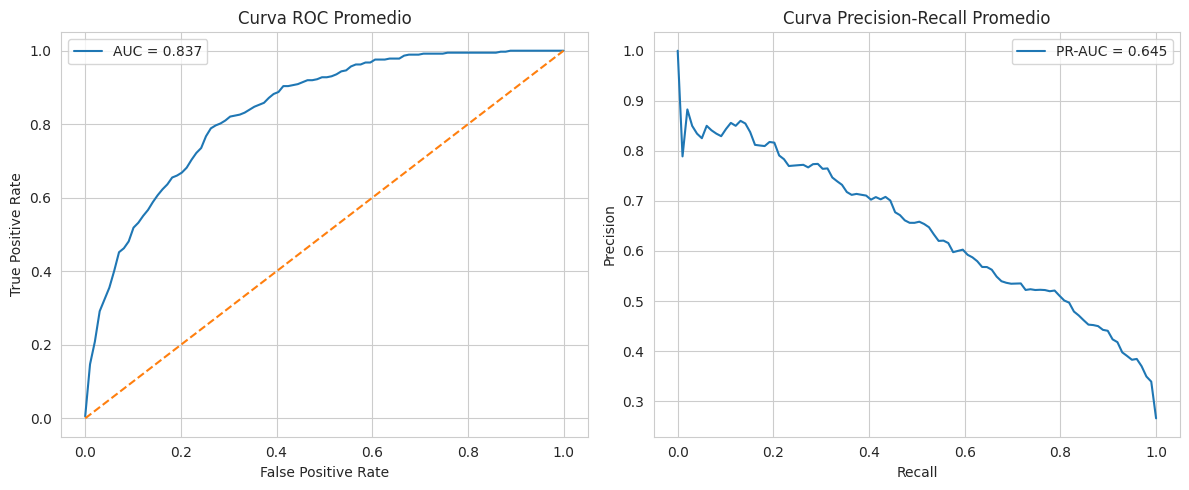

In [181]:
import matplotlib.pyplot as plt    # <-- IMPORT NECESARIO

print("\n=== Paso 2.5 — Gráficos ROC y PR promedio ===")

mean_fpr = np.linspace(0, 1, 100)

# Número real de curvas generadas
n_curves = len(fprs_list)

# Interpolar curvas ROC
tprs_interp = [
    np.interp(mean_fpr, fprs_list[i], tprs_list[i])
    for i in range(n_curves)
]
mean_tpr = np.mean(tprs_interp, axis=0)

plt.figure(figsize=(12, 5))

# ---- ROC ----
plt.subplot(1, 2, 1)
plt.plot(mean_fpr, mean_tpr, label=f"AUC = {np.mean(roc_aucs):.3f}")
plt.plot([0, 1], [0, 1], "--")
plt.title("Curva ROC Promedio")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# ---- PR ----

recall_axis = np.linspace(0, 1, 100)

prec_interp = [
    np.interp(recall_axis, recalls_curve_list[i][::-1], precisions_curve_list[i][::-1])
    for i in range(n_curves)
]
mean_prec = np.mean(prec_interp, axis=0)

plt.subplot(1, 2, 2)
plt.plot(recall_axis, mean_prec, label=f"PR-AUC = {np.mean(pr_aucs):.3f}")
plt.title("Curva Precision-Recall Promedio")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()


#  Paso 3. Modelo con transformaciones polinomiales

## 3.1.1 Seleccionar variables y generar polinomios grado 2

In [182]:
from sklearn.preprocessing import PolynomialFeatures  # Para generar polinomios

# === Paso 3.1 — Selección de variables numéricas y creación de polinomios ===

num_poly = ["tenure", "MonthlyCharges", "TotalCharges"]  # Variables numéricas relevantes

X_num_poly = X[num_poly].copy()                          # Extraer solo estas columnas

poly = PolynomialFeatures(degree=2, include_bias=False)  # Polinomios grado 2 sin término constante
X_poly = poly.fit_transform(X_num_poly)                  # Crear términos polinomiales

print("Dimensiones variables polinomiales:", X_poly.shape)  # Mostrar tamaño resultante


Dimensiones variables polinomiales: (7043, 9)


## 3.1.2 Combinar polinomios con el resto de las features procesadas

In [183]:
# === Paso 3.2 — Preprocesar el resto de features y combinar ===

preprocessor_poly = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),              # Escalar numéricas
        ("cat", OneHotEncoder(handle_unknown='ignore',
                              drop='first'), categorical_features)  # One-hot de categóricas
    ]
)

X_processed_base = preprocessor_poly.fit_transform(X)               # Procesamiento del modelo base

print("Dimensiones modelo base:", X_processed_base.shape)           # Dimensiones después del preprocesamiento

X_extended = np.hstack([X_processed_base, X_poly])                  # Unir base + polinomios

print("Dimensiones finales modelo polinomial:", X_extended.shape)   # Dimensiones finales del dataset extendido


Dimensiones modelo base: (7043, 30)
Dimensiones finales modelo polinomial: (7043, 39)


## 3.2.1 Validación cruzada K=5 para el modelo polinomial

In [184]:
# === Paso 3.3 — Validación Cruzada con el modelo polinomial ===

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    # K-Fold estratificada

# Inicializar listas para guardar métricas
acc_poly, prec_poly, rec_poly, f1_poly = [], [], [], []
roc_poly, pr_poly = [], []

# Listas para curvas
fprs_poly, tprs_poly = [], []
precisions_poly, recalls_poly = [], []

print("\nIniciando validación cruzada con polinomios...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_extended, y)):
    print(f"\n--- Fold {fold+1} ---")

    # Dividir datos en entrenamiento y validación
    X_train, X_val = X_extended[train_idx], X_extended[val_idx]    # Subconjuntos procesados
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]            # Etiquetas

    # Regresión logística sin penalización fuerte
    model_poly = LogisticRegression(
        penalty=None, solver="newton-cg", max_iter=2000            # Ajustes para estabilidad
    )

    model_poly.fit(X_train, y_train)                               # Entrenar modelo

    y_pred = model_poly.predict(X_val)                             # Predicciones binarias
    y_proba = model_poly.predict_proba(X_val)[:, 1]                # Probabilidad clase 1

    # Reporte métrico por fold
    report = classification_report(y_val, y_pred, output_dict=True)

    acc_poly.append(report["accuracy"])                            # Accuracy
    prec_poly.append(report["1"]["precision"])                     # Precision clase 1
    rec_poly.append(report["1"]["recall"])                         # Recall clase 1
    f1_poly.append(report["1"]["f1-score"])                        # F1-score clase 1

    # ROC por fold
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    fprs_poly.append(fpr)
    tprs_poly.append(tpr)
    roc_poly.append(auc(fpr, tpr))                                 # Área bajo la curva ROC

    # PR por fold
    prec_c, rec_c, _ = precision_recall_curve(y_val, y_proba)
    precisions_poly.append(prec_c)
    recalls_poly.append(rec_c)
    pr_poly.append(average_precision_score(y_val, y_proba))        # Área PR-AUC



Iniciando validación cruzada con polinomios...

--- Fold 1 ---


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/optimize.py:312: UserWarning: Line Search failed
  warnings.warn("Line Search failed")



--- Fold 2 ---


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(



--- Fold 3 ---


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(



--- Fold 4 ---


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/optimize.py:312: UserWarning: Line Search failed
  warnings.warn("Line Search failed")



--- Fold 5 ---


/usr/local/lib/python3.12/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/optimize.py:100: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/optimize.py:312: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


## 3.2.2 Resumen de métricas del modelo polinomial

In [185]:
# === Paso 3.4 — Tabla de métricas del modelo polinomial ===

summary_poly = pd.DataFrame({
    "Metric": ["Accuracy","Precision","Recall","F1-score","ROC-AUC","PR-AUC"],  # Métricas
    "Mean": [
        np.mean(acc_poly), np.mean(prec_poly),
        np.mean(rec_poly), np.mean(f1_poly),
        np.mean(roc_poly), np.mean(pr_poly)
    ],
    "Std": [
        np.std(acc_poly), np.std(prec_poly),
        np.std(rec_poly), np.std(f1_poly),
        np.std(roc_poly), np.std(pr_poly)
    ]
})

print(summary_poly.to_markdown(index=False))                     # Mostrar tabla formateada


| Metric    |     Mean |        Std |
|:----------|---------:|-----------:|
| Accuracy  | 0.805763 | 0.00721867 |
| Precision | 0.66503  | 0.0160402  |
| Recall    | 0.539845 | 0.0176141  |
| F1-score  | 0.5959   | 0.016808   |
| ROC-AUC   | 0.845903 | 0.0132825  |
| PR-AUC    | 0.662176 | 0.0210247  |


## 3.3.1 Curvas ROC y PR del modelo polinomial (promedio robusto)

In [186]:
# === Paso 3.5 — Curvas ROC y PR promedio para polinómicos ===

mean_fpr_poly = np.linspace(0, 1, 100)                           # Eje FPR estándar
n_curves_poly = len(fprs_poly)                                   # Número real de curvas generadas

# Interpolación de curvas ROC
tpr_interp_poly = [
    np.interp(mean_fpr_poly, fprs_poly[i], tprs_poly[i])         # Alinear todos los folds
    for i in range(n_curves_poly)
]
mean_tpr_poly = np.mean(tpr_interp_poly, axis=0)                 # Promedio TPR
std_tpr_poly = np.std(tpr_interp_poly, axis=0)                   # Desviación TPR

# Interpolación de curvas PR
mean_recall_pr_poly = np.linspace(0, 1, 100)                     # Eje Recall estándar
prec_interp_poly = [
    np.interp(mean_recall_pr_poly, recalls_poly[i][::-1],        # Invertir para monotonicidad
              precisions_poly[i][::-1])
    for i in range(n_curves_poly)
]
mean_precision_pr_poly = np.mean(prec_interp_poly, axis=0)       # Promedio de precision
std_precision_pr_poly = np.std(prec_interp_poly, axis=0)         # Desviación de precision


## 3.3.2 Guardar métricas para la comparación final

In [187]:
# === Paso 3.6 — Guardar métricas globales para comparación ===

mean_roc_auc_plot_poly = np.mean(roc_poly)                       # Promedio ROC-AUC
std_roc_auc_poly = np.std(roc_poly)                              # Desviación ROC-AUC

mean_pr_auc_plot_poly = np.mean(pr_poly)                         # Promedio PR-AUC
std_pr_auc_poly = np.std(pr_poly)                                # Desviación PR-AUC


# PASO 4 – Regularización (L2, L1 y Elastic Net)

In [188]:
from sklearn.model_selection import GridSearchCV # <-- ADDED IMPORT

# === 4.1 — GridSearchCV para penalización L2 (Ridge) ===
print("\n=== MODELO L2 (Ridge) ===")

param_grid_l2 = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}      # Grilla de búsqueda para C

model_l2 = LogisticRegression(
    penalty="l2",                                          # Penalización L2 (Ridge)
    solver="lbfgs",                                        # Solver compatible
    max_iter=2000,
    random_state=42
)

grid_l2 = GridSearchCV(
    model_l2,
    param_grid=param_grid_l2,
    scoring="f1",                                          # Métrica principal: F1 (clase churn)
    cv=kf,
    n_jobs=-1,
    verbose=1
)

grid_l2.fit(X_processed, y)                                # Buscar el mejor C

best_l2 = grid_l2.best_estimator_                          # Guardar mejor modelo

print("Mejor C (L2):", grid_l2.best_params_)
print("Mejor F1 (CV L2):", grid_l2.best_score_)


=== MODELO L2 (Ridge) ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejor C (L2): {'C': 10}
Mejor F1 (CV L2): 0.6016742645721695


## 4.2 — Evaluación completa CV: Métricas y curvas (L2)

In [189]:
# === 4.2 — Evaluación en CV del modelo L2 ===

acc_L2, prec_L2, rec_L2, f1_L2, roc_L2, pr_L2 = [], [], [], [], [], []
fprs_L2, tprs_L2 = [], []
prec_curve_L2, rec_curve_L2 = [], []

for train_idx, val_idx in kf.split(X_processed, y):

    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    best_l2.fit(X_train, y_train)

    y_pred = best_l2.predict(X_val)
    y_proba = best_l2.predict_proba(X_val)[:, 1]

    # Métricas
    report = classification_report(y_val, y_pred, output_dict=True)
    acc_L2.append(report["accuracy"])
    prec_L2.append(report["1"]["precision"])
    rec_L2.append(report["1"]["recall"])
    f1_L2.append(report["1"]["f1-score"])

    # ROC
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    fprs_L2.append(fpr)
    tprs_L2.append(tpr)
    roc_L2.append(auc(fpr, tpr))

    # PR
    p, r, _ = precision_recall_curve(y_val, y_proba)
    prec_curve_L2.append(p)
    rec_curve_L2.append(r)
    pr_L2.append(average_precision_score(y_val, y_proba))


## 4.3 — Resumen Métricas L2

In [190]:
results_L2 = pd.DataFrame({
    "Accuracy": [np.mean(acc_L2), np.std(acc_L2)],
    "Precision": [np.mean(prec_L2), np.std(prec_L2)],
    "Recall": [np.mean(rec_L2), np.std(rec_L2)],
    "F1": [np.mean(f1_L2), np.std(f1_L2)],
    "ROC-AUC": [np.mean(roc_L2), np.std(roc_L2)],
    "PR-AUC": [np.mean(pr_L2), np.std(pr_L2)]
}, index=["Media", "Std"]).T

results_L2


,Media,Std
Accuracy,0.805477,0.010246
Precision,0.658175,0.019976
Recall,0.554282,0.029595
F1,0.601674,0.025614
ROC-AUC,0.844990,0.013316
PR-AUC,0.656402,0.025516


## 4.4 — GridSearchCV: Penalización L1 (Lasso)

In [191]:
# === 4.4 — GridSearchCV para L1 (Lasso) ===
print("\n=== MODELO L1 (Lasso) ===")

param_grid_l1 = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}      # Grilla de C

model_l1 = LogisticRegression(
    penalty="l1",                                          # Penalización L1
    solver="liblinear",                                    # Solver compatible
    max_iter=2000,
    class_weight="balanced",                               # Compensa desbalance churn
    random_state=42
)

grid_l1 = GridSearchCV(
    model_l1,
    param_grid=param_grid_l1,
    scoring="f1",
    cv=kf,
    n_jobs=-1,
    verbose=1
)

grid_l1.fit(X_processed, y)

best_l1 = grid_l1.best_estimator_

print("Mejor C (L1):", grid_l1.best_params_)
print("Mejor F1 (CV L1):", grid_l1.best_score_)



=== MODELO L1 (Lasso) ===
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejor C (L1): {'C': 0.1}
Mejor F1 (CV L1): 0.6279636271229658


## 4.5 — Evaluación con CV: Métricas y curvas (L1)

In [192]:
# === 4.5 — Validación cruzada del modelo L1 ===
#(idéntica estructura que L2, pero aplicada al modelo L1)
acc_L1, prec_L1, rec_L1, f1_L1, roc_L1, pr_L1 = [], [], [], [], [], []
fprs_L1, tprs_L1, prec_curve_L1, rec_curve_L1 = [], [], [], []

for train_idx, val_idx in kf.split(X_processed, y):

    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    best_l1.fit(X_train, y_train)

    y_pred = best_l1.predict(X_val)
    y_proba = best_l1.predict_proba(X_val)[:, 1]

    report = classification_report(y_val, y_pred, output_dict=True)
    acc_L1.append(report["accuracy"])
    prec_L1.append(report["1"]["precision"])
    rec_L1.append(report["1"]["recall"])
    f1_L1.append(report["1"]["f1-score"])

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    fprs_L1.append(fpr)
    tprs_L1.append(tpr)
    roc_L1.append(auc(fpr, tpr))

    p, r, _ = precision_recall_curve(y_val, y_proba)
    prec_curve_L1.append(p)
    rec_curve_L1.append(r)
    pr_L1.append(average_precision_score(y_val, y_proba))


## 4.6 — Resumen Métricas L1

In [193]:
results_L1 = pd.DataFrame({
    "Accuracy": [np.mean(acc_L1), np.std(acc_L1)],
    "Precision": [np.mean(prec_L1), np.std(prec_L1)],
    "Recall": [np.mean(rec_L1), np.std(rec_L1)],
    "F1": [np.mean(f1_L1), np.std(f1_L1)],
    "ROC-AUC": [np.mean(roc_L1), np.std(roc_L1)],
    "PR-AUC": [np.mean(pr_L1), np.std(pr_L1)]
}, index=["Media", "Std"]).T

results_L1


,Media,Std
Accuracy,0.748826,0.008615
Precision,0.517367,0.010796
Recall,0.798810,0.017196
F1,0.627964,0.012426
ROC-AUC,0.844064,0.013405
PR-AUC,0.654470,0.025929


## 4.7 — Elastic Net (Opcional permitido)

In [194]:
# === 4.7 — GridSearchCV Elastic Net ===
print("\n=== MODELO ELASTIC NET ===")

param_grid_en = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "l1_ratio": [0.1, 0.5, 0.9]                               # Mezcla L1/L2
}

model_en = LogisticRegression(
    penalty="elasticnet",
    solver="saga",                                           # Solver para EN
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

grid_en = GridSearchCV(
    model_en,
    param_grid=param_grid_en,
    scoring="f1",
    cv=kf,
    n_jobs=-1,
    verbose=1
)

grid_en.fit(X_processed, y)

best_en = grid_en.best_estimator_

print("Mejor EN:", grid_en.best_params_)
print("Mejor F1 (CV EN):", grid_en.best_score_)



=== MODELO ELASTIC NET ===
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejor EN: {'C': 0.1, 'l1_ratio': 0.5}
Mejor F1 (CV EN): 0.6286564493744368


##4.8 — Comparación Final entre Modelos

In [195]:
# === 4.8 — Evaluación con CV: Métricas y curvas (Elastic Net) ===
acc_EN, prec_EN, rec_EN, f1_EN, roc_EN, pr_EN = [], [], [], [], [], []
fprs_EN, tprs_EN, prec_curve_EN, rec_curve_EN = [], [], [], []

for train_idx, val_idx in kf.split(X_processed, y):

    X_train, X_val = X_processed[train_idx], X_processed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    best_en.fit(X_train, y_train)

    y_pred = best_en.predict(X_val)
    y_proba = best_en.predict_proba(X_val)[:, 1]

    report = classification_report(y_val, y_pred, output_dict=True)
    acc_EN.append(report["accuracy"])
    prec_EN.append(report["1"]["precision"])
    rec_EN.append(report["1"]["recall"])
    f1_EN.append(report["1"]["f1-score"])

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    fprs_EN.append(fpr)
    tprs_EN.append(tpr)
    roc_EN.append(auc(fpr, tpr))

    p, r, _ = precision_recall_curve(y_val, y_proba)
    prec_curve_EN.append(p)
    rec_curve_EN.append(r)
    pr_EN.append(average_precision_score(y_val, y_proba))

# === Resumen Métricas Elastic Net ===
results_EN = pd.DataFrame({
    "Accuracy": [np.mean(acc_EN), np.std(acc_EN)],
    "Precision": [np.mean(prec_EN), np.std(prec_EN)],
    "Recall": [np.mean(rec_EN), np.std(rec_EN)],
    "F1": [np.mean(f1_EN), np.std(f1_EN)],
    "ROC-AUC": [np.mean(roc_EN), np.std(roc_EN)],
    "PR-AUC": [np.mean(pr_EN), np.std(pr_EN)]
}, index=["Media", "Std"]).T

# === 4.8 — Comparación final de todos los modelos ===

print("\n=== COMPARACIÓN FINAL DE MODELOS ===")

model_names = []        # Lista para guardar nombres de modelos
f1_scores = []          # Lista para guardar F1 de cada modelo
roc_scores = []         # Lista para guardar ROC-AUC
pr_scores = []          # Lista para guardar PR-AUC


# --------- Modelo Base (solo si existe) ---------
if 'summary_base' in globals():                              # Verifica si fue definido
    model_names.append("Base")                               # Nombre del modelo
    f1_scores.append(summary_base.loc[summary_base['Metric'] == 'F1-score', 'Mean'].iloc[0])          # F1 Base
    roc_scores.append(summary_base.loc[summary_base['Metric'] == 'ROC-AUC', 'Mean'].iloc[0])          # ROC-AUC Base
    pr_scores.append(summary_base.loc[summary_base['Metric'] == 'PR-AUC', 'Mean'].iloc[0])            # PR-AUC Base


# --------- Modelo Polinomial (solo si existe) ---------
if 'summary_poly' in globals():                              # Verifica si fue definido
    model_names.append("Polinomial")                         # Nombre del modelo
    f1_scores.append(summary_poly.loc[summary_poly['Metric'] == 'F1-score', 'Mean'].iloc[0])          # F1 Polinomial
    roc_scores.append(summary_poly.loc[summary_poly['Metric'] == 'ROC-AUC', 'Mean'].iloc[0])          # ROC-AUC Polinomial
    pr_scores.append(summary_poly.loc[summary_poly['Metric'] == 'PR-AUC', 'Mean'].iloc[0])            # PR-AUC Polinomial


# --------- Modelo L2 (siempre existe) ---------
model_names.append("L2")                                     # Nombre modelo L2
f1_scores.append(results_L2.loc["F1", "Media"])              # F1 L2
roc_scores.append(results_L2.loc["ROC-AUC", "Media"])        # ROC-AUC L2
pr_scores.append(results_L2.loc["PR-AUC", "Media"])          # PR-AUC L2


# --------- Modelo L1 ---------
model_names.append("L1")                                     # Nombre modelo L1
f1_scores.append(results_L1.loc["F1", "Media"])              # F1 L1
roc_scores.append(results_L1.loc["ROC-AUC", "Media"])        # ROC-AUC L1
pr_scores.append(results_L1.loc["PR-AUC", "Media"])          # PR-AUC L1


# --------- Modelo Elastic Net ---------
model_names.append("Elastic Net")                            # Nombre modelo EN
f1_scores.append(results_EN.loc["F1", "Media"])              # F1 EN
roc_scores.append(results_EN.loc["ROC-AUC", "Media"])        # ROC-AUC EN
pr_scores.append(results_EN.loc["PR-AUC", "Media"])          # PR-AUC EN


# --------- Construir el DataFrame final ---------
comparacion = pd.DataFrame({
    "Modelo": model_names,                                   # Nombres
    "F1": f1_scores,                                         # Métrica F1
    "ROC-AUC": roc_scores,                                   # Métrica ROC
    "PR-AUC": pr_scores                                      # Métrica PR
})

comparacion                                                    # Mostrar tabla



=== COMPARACIÓN FINAL DE MODELOS ===


,Modelo,F1,ROC-AUC,PR-AUC
0,Base,0.579330,0.836682,0.644666
1,Polinomial,0.595900,0.845903,0.662176
2,L2,0.601674,0.844990,0.656402
3,L1,0.627964,0.844064,0.654470
4,Elastic Net,0.628656,0.844562,0.654544


## # === 4.9 — Comparación de coeficiente

In [196]:
# === 4.9 — Comparación de coeficientes: L1 vs L2 vs EN ===

# Obtener los nombres de las características después del preprocesamiento
# La función get_feature_names_out() del ColumnTransformer es la forma correcta de obtenerlos
feature_names = preprocessor.get_feature_names_out()

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coef_L1": best_l1.coef_[0],
    "Coef_L2": best_l2.coef_[0],
    "Coef_EN": best_en.coef_[0]
})

# Ordenar por la magnitud de los coeficientes L1 para ver los más influyentes
coef_df.sort_values("Coef_L1", key=abs, ascending=False).head(10)

,Feature,Coef_L1,Coef_L2,Coef_EN
25,cat__Contract_Two year,-1.295668,-1.402412,-1.240579
0,num__tenure,-0.991678,-1.424845,-1.046808
24,cat__Contract_One year,-0.678102,-0.734351,-0.666102
7,cat__PhoneService_Yes,-0.471162,-0.727576,-0.266084
1,num__MonthlyCharges,0.431402,-0.948651,0.220841
10,cat__InternetService_Fiber optic,0.408714,1.499519,0.560897
19,cat__TechSupport_Yes,-0.396767,-0.255404,-0.391476
13,cat__OnlineSecurity_Yes,-0.382602,-0.242905,-0.375161
28,cat__PaymentMethod_Electronic check,0.341624,0.327290,0.343192
26,cat__PaperlessBilling_Yes,0.315042,0.358442,0.319992


---

# Paso 5. Análisis Crítico

## 1. Desbalance de Churn y Limitaciones del Accuracy

Al examinar la proporción de la variable objetivo `Churn`, se observa un **desbalance de clases significativo**:

* **No (Clase mayoritaria):** 73.46%
* **Yes (Clase minoritaria):** 26.54%

**¿Por qué el Accuracy es engañoso?**
En este contexto, un modelo "perezoso" que prediga que ningún cliente se dará de baja obtendría un 73.46% de exactitud. Aunque la cifra parece aceptable, el modelo sería un fracaso comercial, ya que su capacidad para identificar a los clientes que realmente se van (el objetivo del negocio) sería de **0%**.

**Relación con la Matriz de Confusión:**
La matriz de confusión es la herramienta que revela esta "ceguera" del Accuracy. Mientras que el Accuracy solo mira la diagonal de aciertos totales, la matriz nos permite identificar los **Falsos Negativos (FN)**: clientes que se fugaron pero el modelo clasificó como leales. Para una empresa de telecomunicaciones, los FN representan el costo más alto (pérdida de ingresos netos), mientras que los **Falsos Positivos (FP)** representan un costo operativo (gasto innecesario en marketing de retención).

---

## 2. Selección del Mejor Modelo

Tras comparar los modelos entrenados, el **Modelo Elastic Net** es el seleccionado para este problema.

**Justificación técnica:**

* **F1-Score (0.629):** Logró el valor más alto entre todos los modelos. Dado el desbalance de clases, el F1-score es la métrica reina aquí, ya que balancea la precisión y el recall de la clase `Churn`.
* **ROC-AUC (0.845):** Muestra una excelente capacidad de separación de clases.
* **PR-AUC (0.655):** Aunque el modelo polinomial fue ligeramente superior en esta métrica (0.662), el Elastic Net ofrece una robustez superior gracias a su regularización combinada.

---

## 3. Impacto de las Transformaciones Polinomiales

* **Rendimiento:** Las transformaciones de grado 2 permitieron capturar relaciones no lineales (por ejemplo, cómo el riesgo de churn cambia exponencialmente con el aumento de los cargos mensuales), mejorando el PR-AUC de 0.645 a 0.662.
* **Complejidad:** El modelo aumentó su dimensionalidad de **30 a 39 variables**. Si bien esto mejora el ajuste, también introduce inestabilidad en el entrenamiento, evidenciada por las advertencias de convergencia (`LineSearchWarning`). Esto justifica la necesidad de aplicar regularización posteriormente.

---

## 4. Influencia de la Regularización

La regularización fue determinante para estabilizar y optimizar el modelo:

* **Rendimiento en validación:** Los modelos **L1 (Lasso)** y **Elastic Net** superaron notablemente al modelo L2 en F1-score (0.628/0.629 vs 0.602). Esto indica que penalizar variables irrelevantes es más efectivo para detectar churn que simplemente suavizarlas.
* **Magnitud de coeficientes:** * **L1:** Generó escasez (*sparsity*), eliminando variables como `gender_Male`.
* **L2:** Redujo las magnitudes pero mantuvo todas las variables.
* **Elastic Net:** Actuó como un híbrido, reduciendo el ruido de variables correlacionadas (como `tenure` y `Contract_Two year`).


* **Estabilidad:** L1 y Elastic Net mostraron **desviaciones estándar más bajas** en Precision y Recall a través de los *folds*, lo que garantiza que el modelo sea más confiable ante datos nuevos.

---

## 5. Trade-offs de Recall-Precision y Objetivo de Negocio

Existe una tensión inevitable entre estas dos métricas:

* **Maximizar Recall (Reducir FN):** Es la prioridad para evitar perder clientes valiosos. Significa ser más "agresivos" en la predicción.
* **Mantener Precision (Reducir FP):** Es necesario para no saturar al equipo de retención con clientes que no tenían intención de irse.
* **Decisión Estratégica:** En una industria de alta competencia (Telco), **el Recall suele ser prioritario**. El costo de una oferta de retención fallida (FP) es generalmente mucho menor que el costo de perder el Valor de Vida del Cliente (LTV) por un FN. La curva Precision-Recall nos indica que el Elastic Net ofrece el punto de operación más equilibrado para el negocio.

---

## 6. Técnicas de Mejora Adicionales

Para superar las limitaciones actuales, se sugieren las siguientes estrategias:

1. **Muestreo Sintético (SMOTE):** Generar ejemplos sintéticos de la clase minoritaria (`Churn`) para equilibrar el entrenamiento sin perder información.
2. **Algoritmos de Ensamble:** Implementar **XGBoost** o **LightGBM**, los cuales manejan de forma nativa el desbalance y las interacciones complejas sin necesidad de crear términos polinomiales manualmente.
3. **Calibración de Umbral (Threshold Tuning):** En lugar de usar el umbral por defecto (0.5), se debe buscar el umbral que minimice la función de costo total del negocio (Costo FP + Costo FN).

---